Attribution:
The idea is orginally created  by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). The original BigGAN + CLIP method was made by https://twitter.com/advadnoun.

# Load Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download pre trained models

In [2]:
!git clone https://github.com/openai/CLIP.git # CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs.
!git clone https://github.com/CompVis/taming-transformers # for high quality image synthesis which learns a codebook of context-rich visual parts

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'taming-transformers' already exists and is not an empty directory.


#Loading Libraries

In [3]:
## install some extra libraries
!pip install --no-deps ftfy regex tqdm #ftfy - ftfy fixes Unicode that's broken in various ways, Regex for seach patttern, extensible progress bar
#  pytorch lightning deep learning framework for performance at scale ,
# Omegaconf hierarchical configuration system, with support for merging configurations f
!pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
!pip uninstall torchtext --yes
!pip install einops # for tensor operations
!pip install ftfY

In [ ]:
!pip uninstall torch -y
!pip install torch==1.13.1 torchvision torchaudio


In [6]:
from CLIP import clip # Import Clip model
print(clip.available_models()) # See the available models

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [7]:
# import libraries
from omegaconf import OmegaConf
import numpy as np # for arrays and matrix operations
import torch, os, imageio, pdb, math
import torchvision # for computer vision dataset, transformation and model architectures g
import torchvision.transforms as T # common image transformation
import torchvision.transforms.functional as TF  # fine garain control over transformations
import PIL # Python interpreter for image editing (Pillow)
import matplotlib.pyplot as plt # for visualization
import yaml #Markup language


In [8]:
device=torch.device("cuda:0")
torch.cuda.empty_cache()

# Utility functions

In [ ]:
def create_dir():
  os.makedirs('taming-transformers/models/vqgan/checkpoints')
  os.makedirs ('taming-transformers/models/vqgan/configs')
create_dir()

In [10]:
# Normalization based on pretrained data
normalize = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

#creation of clip encoding
def encodeText(text):
  t=clip.tokenize(text).cuda() # tokenization
  t=clipmodel.encode_text(t).detach().clone() # encoding
  return t

# Inclusion and Exclusion of particulars
def createEncodings(include, exclude, extras):
  include_encoding=[]
  for text in include:
    include_encoding.append(encodeText(text))
  exclude_encoding=encodeText(exclude) if exclude != '' else 0 # create clip embedding
  extras_encoding=encodeText(extras) if extras !='' else 0 # create clip embedding

  return include_encoding, exclude_encoding, extras_encoding

In [11]:
## Utility functions

def show_from_tensor(tensor):
  img = tensor.clone()
  img = img.mul(255).byte()
  img = img.cpu().numpy().transpose((1,2,0)) # CWH

  plt.figure(figsize=(10,7))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

def norm_data(data):
  return (data.clip(-1,1)+1)/2 ### range between 0 and 1 in the result

In [12]:
# Image augmentations and transformations
img_agumentation = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(45, (.3, .3))
).cuda()

In [13]:
### Parameters
Size_Height1, Size_Width2, channels = [450, 450, 3]
lr = .5
batch_size = 1
wd = .1  # Weight decay by optimizer
noise_ftr = .22
iter=100

# Loading Model

In [14]:
### CLIP MODEL ###
clipmodel, _ = clip.load('ViT-B/32', jit=False) # Clip using visual transformer
clipmodel.eval() # Setting for evaluatoin model
print("Clip model visual input resolution: ", clipmodel.visual.input_resolution)
device=torch.device("cuda:0")
torch.cuda.empty_cache()

Clip model visual input resolution:  224


In [ ]:
## Taming transformer instantiation
!wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'taming-transformers/models/vqgan/checkpoints/last.ckpt'
!wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'taming-transformers/models/vqgan/configs/model.yaml'


In [16]:
# Initiate the pre-trained transformers
# Latent space of shape (1, 256, 16, 16) = 65536 dimensions.
# */content/taming-transformers/taming/data/utils.py - remove from torch._six import string_classes

%cd taming-transformers
from torch import inf
from taming.models.vqgan import VQModel
config_model = OmegaConf.load("./models/vqgan/configs/model.yaml")

VQ_model = VQModel(**config_model.model.params)
state_dict = torch.load("./models/vqgan/checkpoints/last.ckpt", map_location="cpu")["state_dict"] # loading parameters
VQ_model.load_state_dict(state_dict, strict=False)
Generator_model=VQ_model.eval().to(device) # used for inference

def generator(x):
  x = Generator_model.post_quant_conv(x) # Convolutional part of transformer
  x = Generator_model.decoder(x) # pass the Conv output to decoder part of transformer
  return x

/content/taming-transformers
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 355kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [17]:
class Opt_Param(torch.nn.Module): # Optimization parameters
  def __init__(self):
    super(Opt_Param, self).__init__()
    self.data = .5*torch.randn(batch_size, 256, Size_Height1//16, Size_Width2//16).cuda() # 1x256x(450/16)x(450/16)
    self.data = torch.nn.Parameter(torch.sin(self.data)) # sin to embed position of parameter

  def forward(self):
    return self.data

def init_params():
  params=Opt_Param().cuda() # Resetting parameters
  optimizer = torch.optim.AdamW([{'params':[params.data], 'lr': lr}], weight_decay=wd) # Declare optimizer
  return params, optimizer

torch.Size([1, 256, 28, 28])
img dimensions:  torch.Size([1, 3, 448, 448])


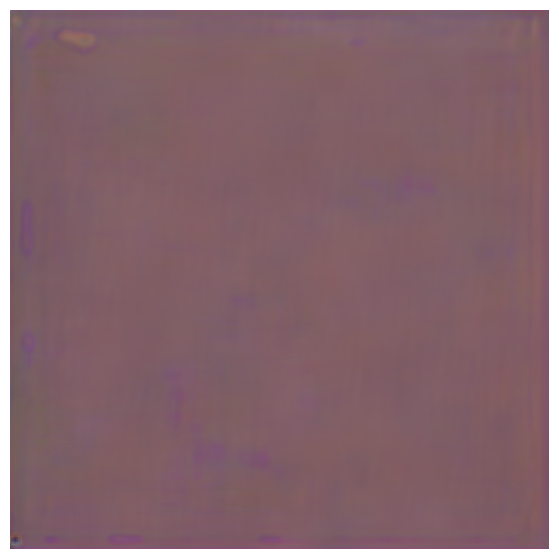

In [18]:
Params, optimizer = init_params()

with torch.no_grad():
  print(Params().shape)
  img= norm_data(generator(Params()).cpu()) # 1 x 3 x 448 x 448
  print("img dimensions: ",img.shape)
  show_from_tensor(img[0])



In [19]:
### create crops

def Img_Crops(img, no_crops=40):
  p=Size_Height1//2
  img = torch.nn.functional.pad(img, (p,p,p,p), mode='constant', value=0) # (adding 225*2 on all sides to 450x450)

  img = img_agumentation(img) #RandomHorizontalFlip and RandomAffine

  Img_Crops_Set = []
  for ch in range(no_crops):
    gap1= int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * Size_Height1)
    offsetx = torch.randint(0, int(Size_Height1*2-gap1),())
    offsety = torch.randint(0, int(Size_Height1*2-gap1),())

    crop=img[:,:,offsetx:offsetx+gap1, offsety:offsety+gap1]

    crop = torch.nn.functional.interpolate(crop,(224,224), mode='bilinear', align_corners=True) # resized to 224,224 to fit Clip model using interpolation method
    Img_Crops_Set.append(crop)

  img_crops=torch.cat(Img_Crops_Set,0) ## 30 x 3 x 224 x 224 i.e 30 crops send to clip

  randnormal = torch.randn_like(img_crops, requires_grad=False)
  num_rands=0
  randstotal=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  for ns in range(num_rands):
    randstotal*=torch.rand((img_crops.shape[0],1,1,1)).cuda()

  img_crops = img_crops + noise_ftr*randstotal*randnormal # adding noise for stochasticity

  return img_crops




In [20]:
### Show current state of generation

def vis(Params):
  with torch.no_grad():
    generated = generator(Params())
    latest_gen=norm_data(generated.cpu())
    show_from_tensor(latest_gen[0])

  return (latest_gen[0])

In [21]:
# Optimization process

def optimize_result(Params, prompt):
  alpha=1 # hyper paramerters importance of include encoding
  beta=.5 ## hyper parameters importance of exclue encloding

  ## image encoding
  out = generator(Params()) # generate new image
  out = norm_data(out) # normalize the result
  out = Img_Crops(out) # create crops 30x224x224
  out = normalize(out) # extra normalizations required for pretrained clip
  image_enc=clipmodel.encode_image(out) ## get image encoding 30x512

  ## text encoding  weight1 and weight2
  text_encoding = weight1*prompt + weight2*extras_encoding # prompt and extras_encoding : 1 x 512
  text_encoding_include = text_encoding / text_encoding.norm(dim=-1, keepdim=True) # 1 x 512 # final include encoding
  text_encoding_exclude = exclude_encoding #final exclude encoding

  ## calculate the loss
  inctext_img_loss = torch.cosine_similarity(text_encoding_include, image_enc, -1) # cosine similarity between include text and image vectors
  exctext_img_loss = torch.cosine_similarity(text_encoding_exclude, image_enc, -1) # # cosine similarity between exclude text and image vectors

  final_loss = -alpha*inctext_img_loss + beta*exctext_img_loss

  return final_loss

def optimize(Params, optimizer, prompt):
  loss = optimize_result(Params, prompt).mean() # average loss of crops
  optimizer.zero_grad() # set zero gradient
  loss.backward() # backward propogation
  optimizer.step() # change the parameters
  return loss


In [22]:
### training loop

def training_loop(Params, optimizer):
  res_image=[]
  res__latent_z=[]

  for prompt in include_encoding:
    iteration=0
    Params, optimizer = init_params() #1x256x(450/16)x(450/16)

    for it in range(iter):
      loss = optimize(Params, optimizer, prompt)

      if iteration>=80 and iteration%show_step == 0:
        newimg = vis(Params)
        res_image.append(newimg)
        res__latent_z.append(Params()) #1x256x(450/16)x(450/16)
        print("loss:", loss.item(), "\niteration:",iteration)

      iteration+=1
    torch.cuda.empty_cache()
  return res_image, res__latent_z


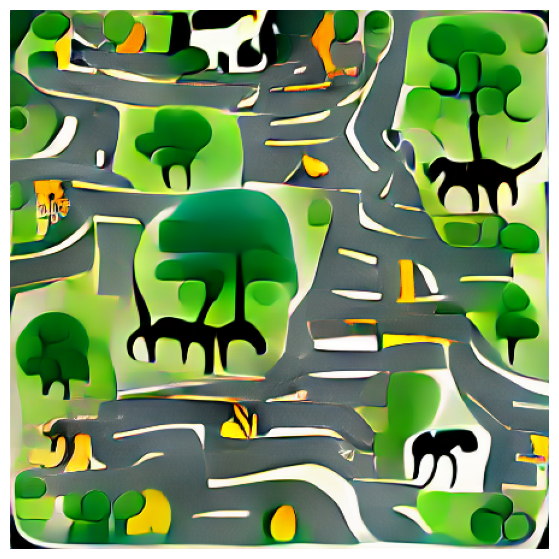

loss: -0.2666015625 
iteration: 199


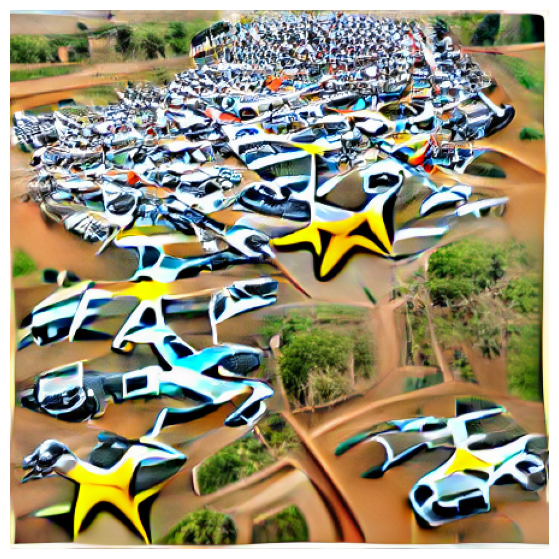

loss: -0.2249755859375 
iteration: 199


In [23]:
torch.cuda.empty_cache()
include=['Road with animals and trees', '100 Cars flying in the sapce']
exclude='Red, low resolution , bright , cropped, incoherent, blurry'
extras = ""
weight1=1
weight2=1
noise_ftr= .22
iter=200
show_step=iter-1 # set this if you want to interpolate between only the final versions
include_encoding, exclude_encoding, extras_encoding = createEncodings(include, exclude, extras)
res_image, res__latent_z=training_loop(Params, optimizer)
